In [0]:
!pip install tqdm
!pip install keras
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers




Using TensorFlow backend.


In [0]:
ndim = 10 #noise dimensions

(X_train, y_train), (X_test, y_test) =mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5 #normalization
X_train = X_train.reshape(60000, 784) #reshaping 28*28 to 784

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
adam = Adam(lr=0.0002, beta_1=0.5)

generator = Sequential()
generator.add(Dense(256, input_dim=ndim)) #give output dimension of size 256 and takes input of 100
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh')) #784 because dimension of input is 784=28*28
generator.compile(loss='binary_crossentropy', optimizer=adam) #tanh because ian goodfellow said so

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam) #tlogO+ (1-t)log(1-O)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# combined network
discriminator.trainable = False #we make this false becase we dont want discrimainator to learn from generated images when it passes through it
ganInput = Input(shape=(ndim,))
x = generator(ganInput)
ganOutput = discriminator(x)

#print ganOutput
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []



In [0]:
#generate using matlolib
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, ndim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)



In [0]:
def saveModels(epoch):
    generator.save('gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('gan_discriminator_epoch_%d.h5' % epoch)


In [0]:
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize #total no. of batches
    print ('epochs:', epochs)
    print ('batch size:', batchSize)
    print ('batches per epoch:', batchCount)
    print (generator.summary())
    print (discriminator.summary())

    for e in range(1, epochs+1):
        print('Epoch %d' % e)
        for tj in tqdm(range(int(batchCount))):
            
            noise = np.random.normal(0, 1, size=[batchSize, ndim])  # random set of input noise and images
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            
            generatedImages = generator.predict(noise)  # generate images
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            
            yDis = np.zeros(2*batchSize)  # Labels for generated and real data
            
            yDis[:batchSize] = 0.9 #create an array of equal no. of 0.9,0 [0.9,0.9...... 0,0,0]
            

            
            discriminator.trainable = True # train discriminator
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, ndim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        
        dLosses.append(dloss)
        gLosses.append(gloss)
        plotGeneratedImages(e)
        saveModels(e)
        
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % e)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  0%|          | 0/468 [00:00<?, ?it/s]

epochs: 8
batch size: 128
batches per epoch: 468.75
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2816      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)         

  1%|          | 5/468 [00:00<00:10, 44.72it/s]

Epoch 2


  1%|          | 5/468 [00:00<00:10, 45.65it/s]

Epoch 3


  1%|          | 5/468 [00:00<00:09, 47.62it/s]

Epoch 4


  1%|          | 5/468 [00:00<00:09, 47.10it/s]

Epoch 5


  1%|          | 5/468 [00:00<00:10, 45.07it/s]

Epoch 6


  1%|          | 5/468 [00:00<00:10, 44.71it/s]

Epoch 7


  1%|          | 5/468 [00:00<00:09, 46.62it/s]

Epoch 8


100%|██████████| 468/468 [00:09<00:00, 48.36it/s]


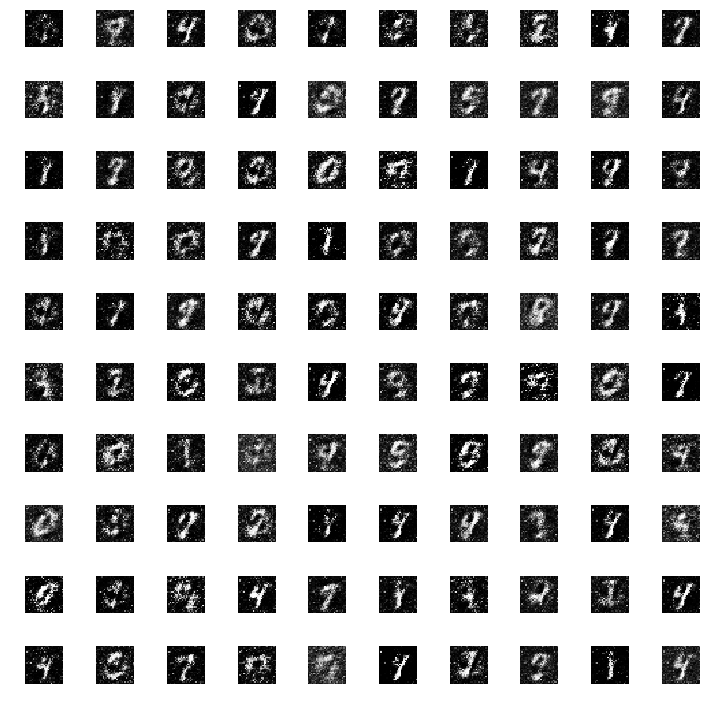

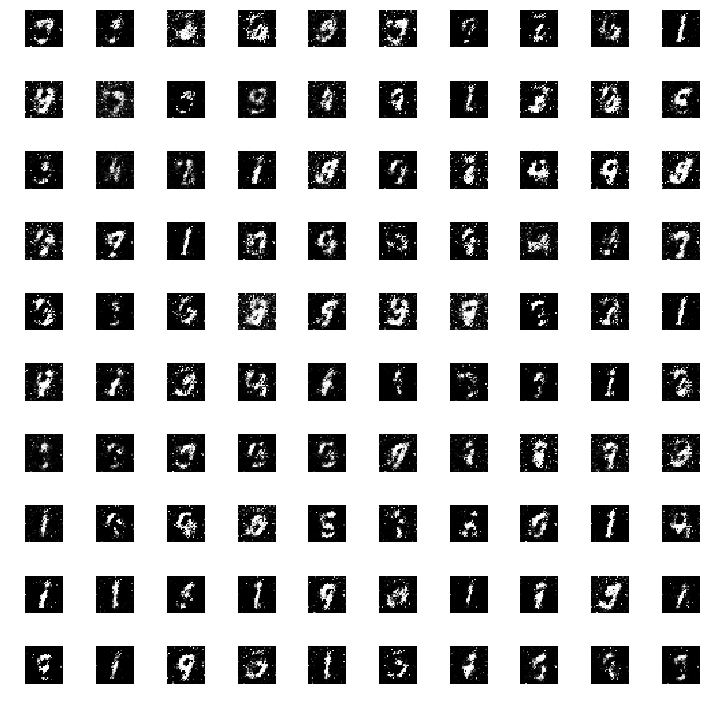

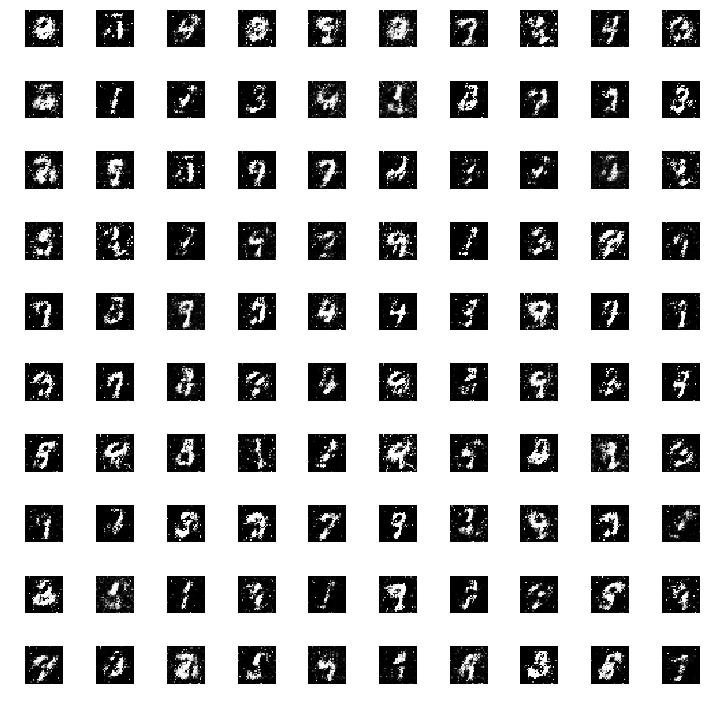

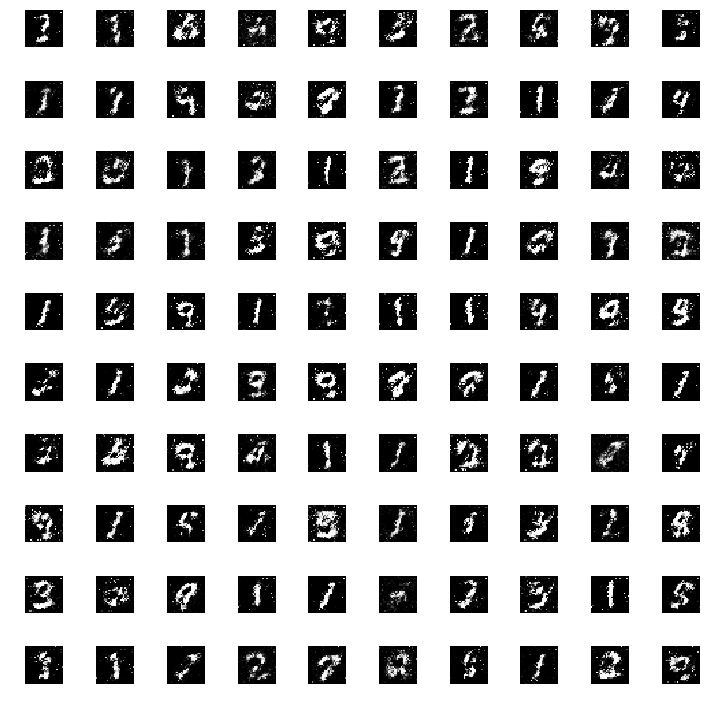

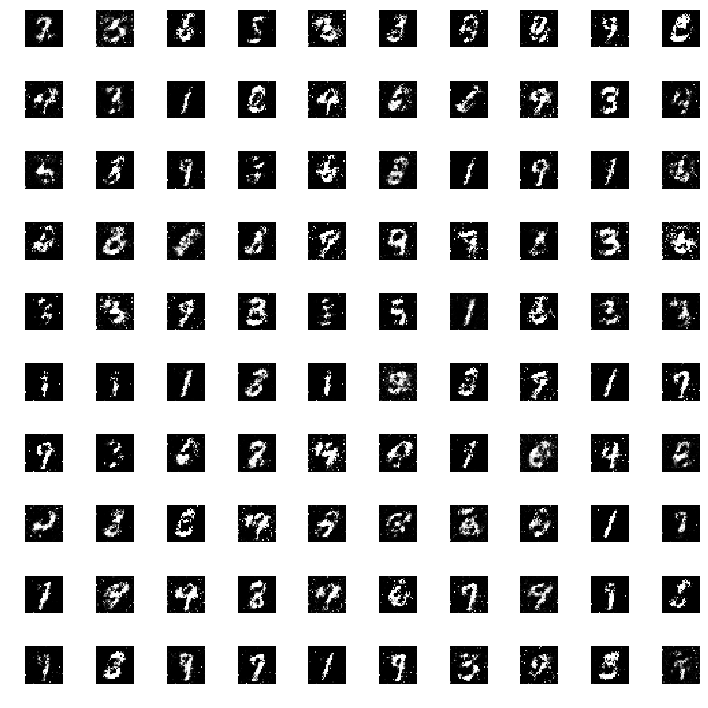

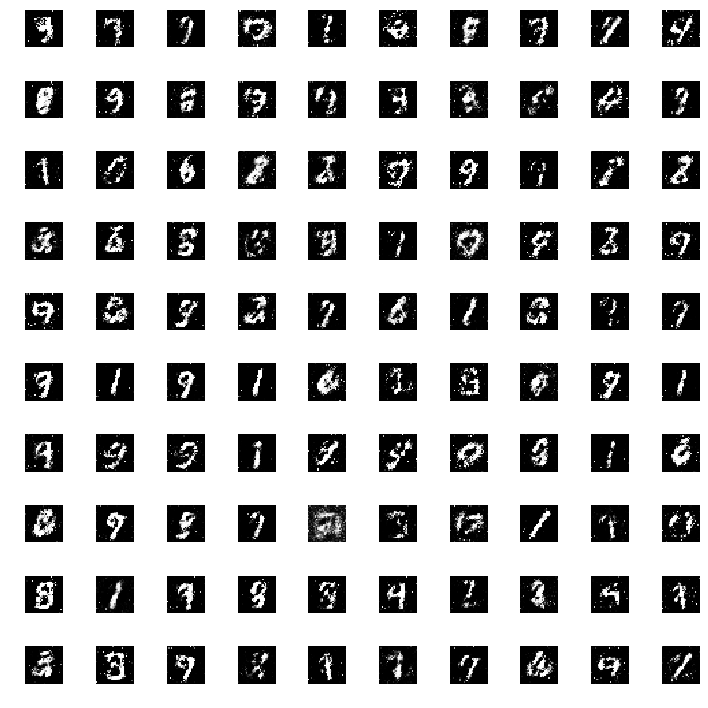

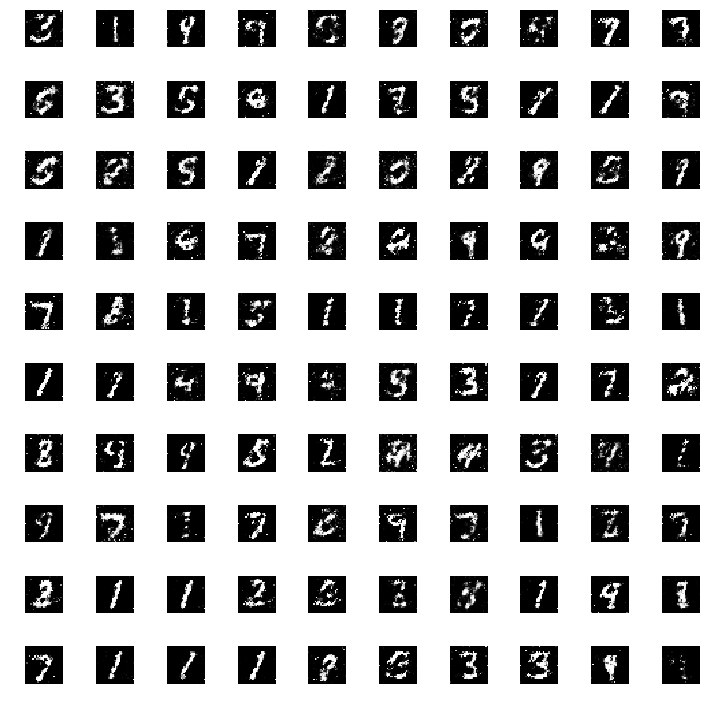

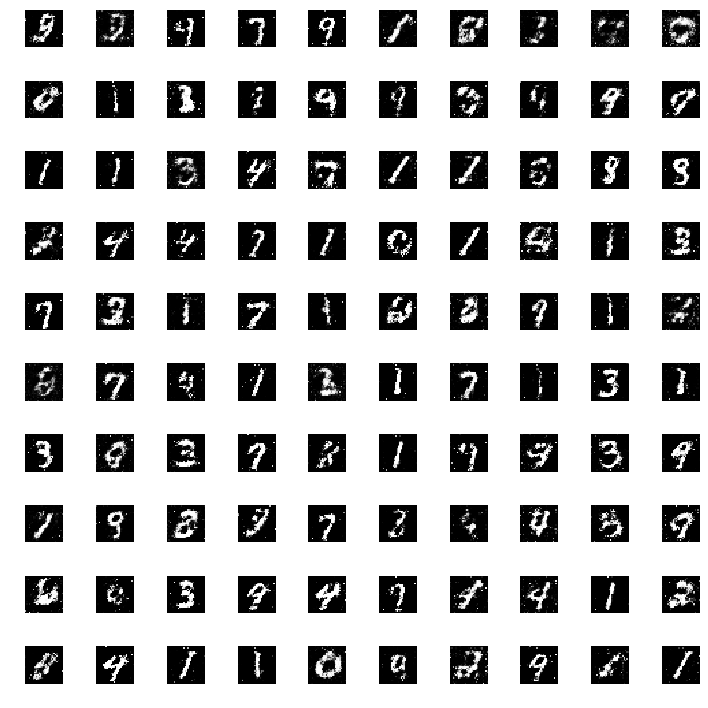

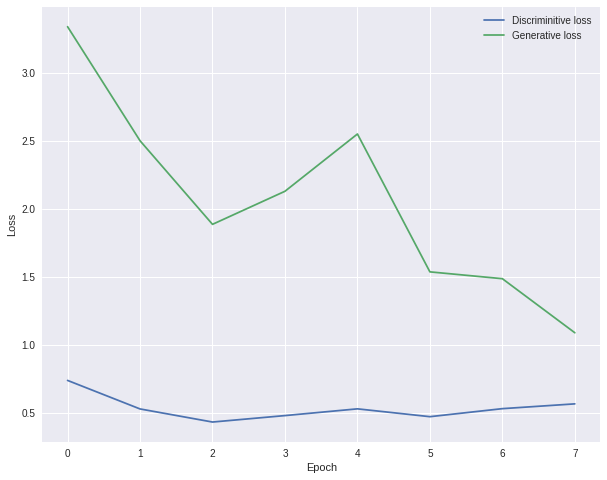

In [0]:

if __name__ == '__main__':
    train(8, 128)